### 필요 라이브러리 

In [10]:
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import numpy as np

### CIFAR-10 데이터셋 로드

In [11]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

### 클래스 이름 정의

In [12]:
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

### 일부 테스트 데이터 라벨 변경 및 시각화
- 특정 테스트 이미지(noise_ids)의 라벨을 new_labels로 변경 후 시각화

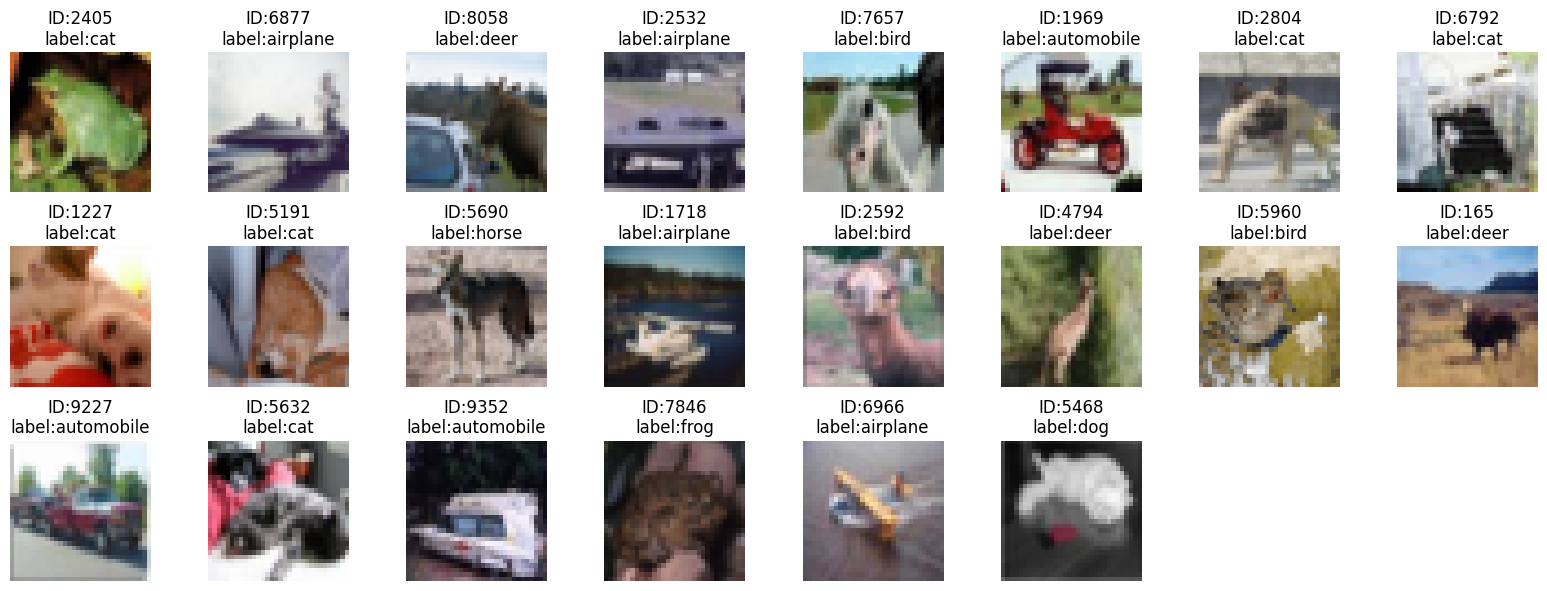

In [ ]:
def show_images(noise_ids, x_data, y_data, class_names, cols=8):
    images = len(noise_ids) # 이미지 개수
    rows = (images + cols - 1) // cols # 행 개수

    plt.figure(figsize=(cols*2, rows*2))
    for i, test_id in enumerate(noise_ids):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x_data[test_id])
        plt.title(f"ID:{test_id}\nlabel:{class_names[y_data[test_id][0]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 라벨을 변경할 테스트 데이터 인덱스 
noise_ids = [
            2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690,
            1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468
            ]
show_images(noise_ids, X_test, y_test, class_names, cols=8)



### 클래스 목록 출력

In [14]:
def print_class(class_names):
    print("CIFAR-10 클래스 목록:")
    for idx, name in enumerate(class_names):
        print(f"{idx}: {name}")

print_class(class_names)

CIFAR-10 클래스 목록:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


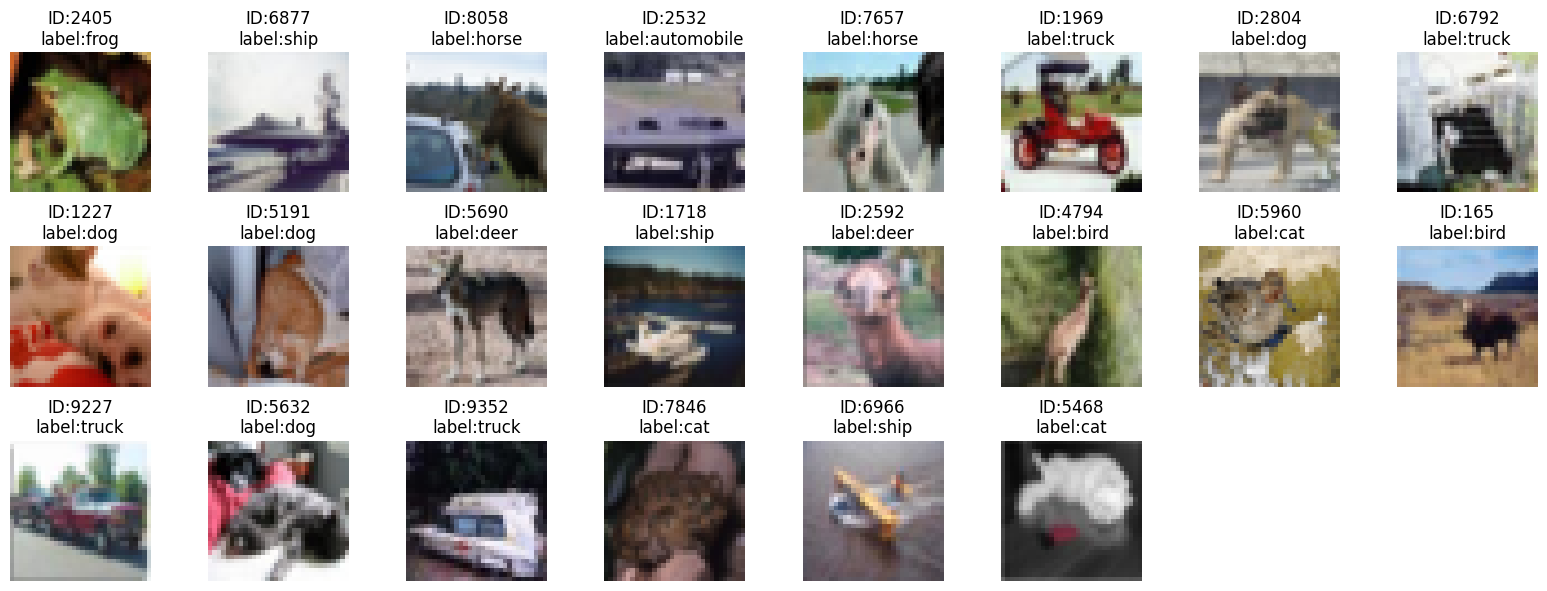

In [ ]:
def change_labels(noise_ids, new_labels, y_data, class_names=None):
    # noise_ids에 해당하는 y_data 라벨을 new_labels로 변경
    for idx, test_id in enumerate(noise_ids):
        new_label = new_labels[idx]
        y_data[test_id] = [new_label]

# 시각화 함수
def show_images(noise_ids, x_data, y_data, class_names, n_cols=8):
    images = len(noise_ids)
    row = (images + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols*2, row*2))
    for i, test_id in enumerate(noise_ids):
        plt.subplot(row, n_cols, i+1)
        plt.imshow(x_data[test_id])
        plt.title(f"ID:{test_id}\nlabel:{class_names[y_data[test_id][0]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

noise_ids = [
            2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690,
            1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468
            ]
# 변경할 라벨 목록
new_labels = [
            6, 8, 7, 1, 7, 9, 5, 9, 5, 5, 4, 8, 4, 2, 3, 2, 9, 5, 9, 3, 8, 3 
            ]
change_labels(noise_ids, new_labels, y_test, class_names)
show_images(noise_ids, X_test, y_test, class_names, n_cols=8)

### 데이터 정규화 및 원-핫 인코딩

In [16]:
# 픽셀값 정규화 (0~1)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# 라벨을 원-핫 인코딩
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

### 학습/검증 데이터 분할

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 10)
(10000, 10)


### 모델 설계 및 하이퍼파라미터 튜닝

In [ ]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        # 하이퍼파라미터에 따라 모델 생성
        model = self.hypermodel.build(trial.hyperparameters)
        # 배치 크기 선택
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)

        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}


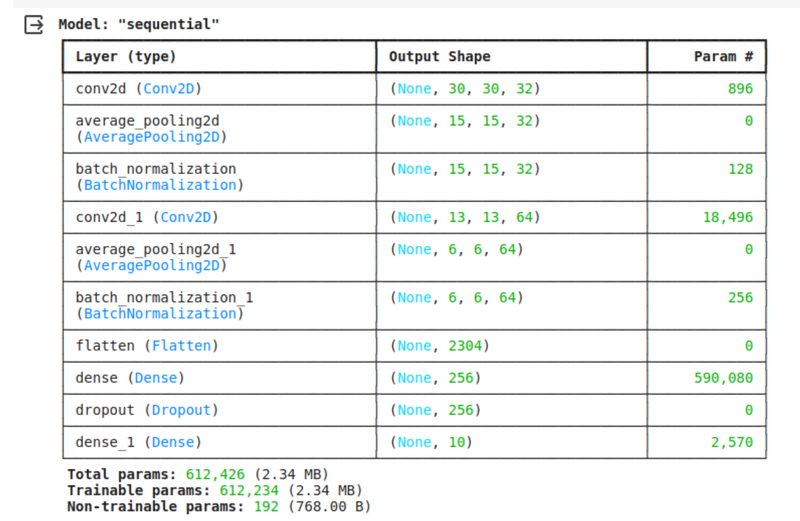

In [ ]:
def build_model(hp):
    # 위와 같은 그림으로 모델을 구성하여 고정해서 사용
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(keras.layers.AveragePooling2D((2, 2)))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.AveragePooling2D((2, 2)))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))  
    # 드롭아웃 비율 하이퍼파라미터 튜닝
    dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1) # 0.2 ~ 0.5
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(10, activation='softmax'))

    # 학습률 하이퍼파라미터 튜닝
    learning_rate = hp.Float('learning_rate', min_value=1e-3, max_value=1e-2, sampling='log') # 0.001 ~ 0.01
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=6, # 최대 시도 횟수
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='cifar10_tuning'
)

tuner.search(
    X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Trial 6 Complete [00h 00m 37s]
accuracy: 0.6863999962806702

Best accuracy So Far: 0.6863999962806702
Total elapsed time: 00h 06m 01s


In [ ]:
# 최적의 하이퍼파라미터를 사용하여 모델 생성
best_hps = tuner.get_best_hyperparameters(num_trials=6)[0] 
model = build_model(best_hps)
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 average_pooling2d_14 (Avera  (None, 15, 15, 32)       0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_14 (Bat  (None, 15, 15, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_15 (Avera  (None, 6, 6, 64)         0         
 gePooling2D)                                                    
                                                      

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs = 20) # 32로 고정

Epoch 1/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.6154 - accuracy: 0.4647
Epoch 2/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.1209 - accuracy: 0.6040
Epoch 3/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.9516 - accuracy: 0.6642
Epoch 4/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.8335 - accuracy: 0.7080
Epoch 5/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.7297 - accuracy: 0.7429
Epoch 6/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.6511 - accuracy: 0.7729
Epoch 7/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.5675 - accuracy: 0.8008
Epoch 8/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.5081 - accuracy: 0.8208
Epoch 9/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.4466 - accuracy: 0.8426
Epoch 10/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.396

In [ ]:
model.evaluate(X_test, y_test) # 테스트 데이터 평가

313/313 [==============================] - 2s 4ms/step - loss: 1.3289 - accuracy: 0.7076


[1.3289406299591064, 0.7075999975204468]

### 모델 저장 및 불러오기

In [24]:
import os

save_path = 'C:/Users/2060/future_an/projects/exploration/aiffel/cifar-10_project/my_model/1'
os.makedirs(save_path, exist_ok=True)
model.save(save_path)


INFO:tensorflow:Assets written to: C:/Users/2060/future_an/projects/exploration/aiffel/cifar-10_project/my_model/1\assets


INFO:tensorflow:Assets written to: C:/Users/2060/future_an/projects/exploration/aiffel/cifar-10_project/my_model/1\assets


### TFLite로 경량화 모델 만들기

In [25]:
load_path = 'C:/Users/2060/future_an/projects/exploration/aiffel/cifar-10_project/my_model/1'
best_model = tf.keras.models.load_model(load_path)

In [26]:
best_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 average_pooling2d_14 (Avera  (None, 15, 15, 32)       0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_14 (Bat  (None, 15, 15, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_15 (Avera  (None, 6, 6, 64)         0         
 gePooling2D)                                                    
                                                      

### tflite 파일로 변환

In [ ]:
# TFLite 포맷으로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Public\Documents\ESTsoft\CreatorTemp\tmpx1mp4gmw\assets


INFO:tensorflow:Assets written to: C:\Users\Public\Documents\ESTsoft\CreatorTemp\tmpx1mp4gmw\assets


In [ ]:
# 변환된 tflite 모델 파일로 저장
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

### tflite파일이 변환이 잘 되었는지 확인하기 위해 서명부분 확인

In [ ]:
# TFLite 모델 로드 및 서명 확인
interpreter = tf.lite.Interpreter(model_content=tflite_model)

signatures = interpreter.get_signature_list()
print(signatures)

{'serving_default': {'inputs': ['conv2d_14_input'], 'outputs': ['dense_15']}}


In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

### TFServing Docker로 실습

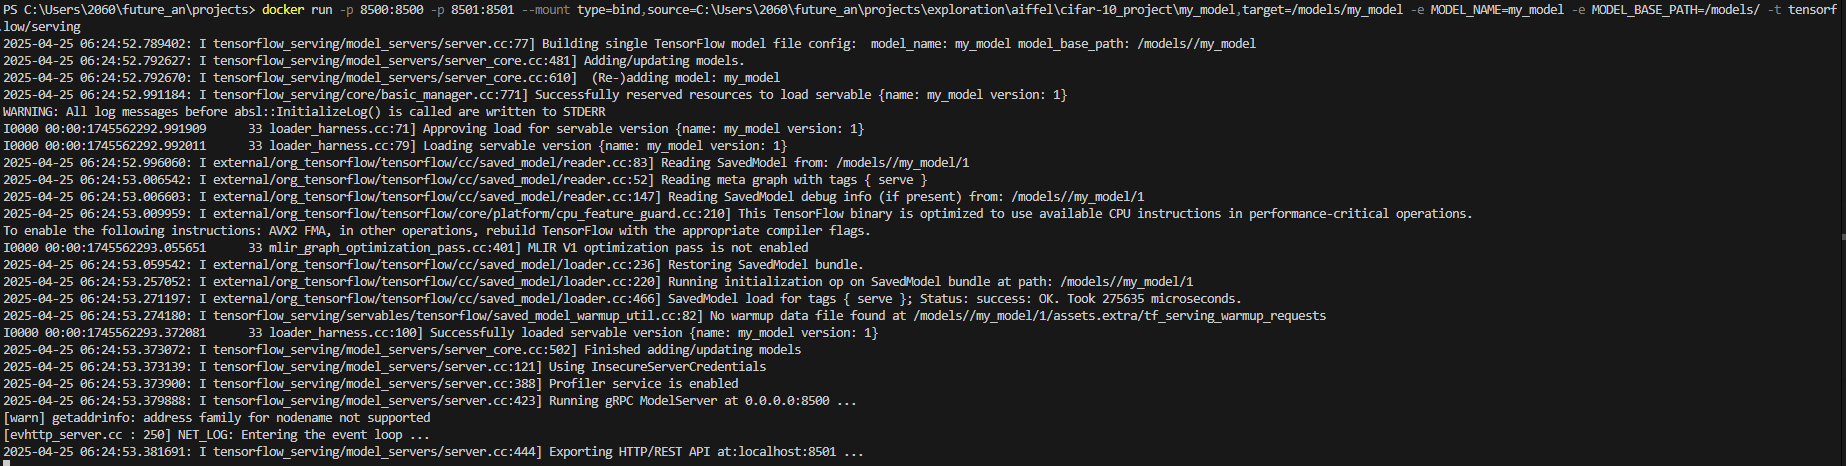

In [ ]:
# Keras 모델을 .keras 확장자로 저장 (TF Serving용)
save_path = 'C:/Users/2060/future_an/projects/exploration/aiffel/cifar-10_project/my_model/1'

fname2 = os.path.join(save_path, 'cifar10_model.keras')
model.save(fname2)

#### 테스트 데이터 이미지 하나 예측 (TFServing API 사용)

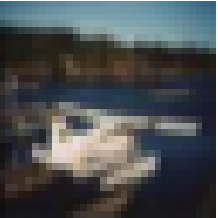

In [4]:
from PIL import Image
import numpy as np
import requests

# CIFAR-10 클래스 이름 정의
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# 이미지 불러오기 및 전처리
img = Image.open('C:/Users/2060/Downloads/1718.png').resize((32, 32))
img = np.array(img)
img = img[..., :3]
img = img.astype(np.float32) / 255.0  # 정규화

# 예측 요청
response = requests.post(
    "http://localhost:8501/v1/models/my_model:predict",
    json={"instances": [img.tolist()]}
)

if response.status_code == 200:
    predictions = response.json()["predictions"]
    predicted_class = int(np.argmax(predictions[0]))
    confidence = float(np.max(predictions[0]))
    label = class_names[predicted_class]
    print(f"예측 결과: {predicted_class} ({label}) (신뢰도: {confidence:.2%})")
else:
    print("에러 발생:", response.text)


예측 결과: 8 (ship) (신뢰도: 86.96%)
